
# ViT Chest X‑ray — Scratch & Pretrained (Ready to Run)

This notebook trains **two** Vision Transformer models on the Kaggle *Chest X‑ray Pneumonia* dataset and evaluates them with a  policy suitable for screening:

1. **Custom ViT (from scratch)** — minimal ViT as in the paper (patch‑linear‑embed → add [CLS]+pos → L×{Pre‑LN → MSA → residual → Pre‑LN → MLP(GELU) → residual} → LN → [CLS] → linear head).  
2. **Pretrained ViT‑B/16** (Google JAX `.npz` weights) — offline; no internet needed.

We report metrics at **@0.5** and at a  operating point chosen on validation (`mode="loose"`), then compare both models.

> **Prereqs**
>
> - Dataset at `../Data/chest_xray` (relative to this notebook), with subfolders `train/`, `val/`, `test/` as on Kaggle.  
> - For **pretrained** run: put Google weights at `./weights/ViT-B_16.npz` (relative to this notebook).  
> - macOS/MPS supported; `pin_memory=False` to avoid warnings.


In [34]:

# === Imports & basic config ===
from dataclasses import dataclass
from pathlib import Path
import time, math, os, random
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, precision_recall_curve, roc_curve, average_precision_score
)
from sklearn.model_selection import StratifiedShuffleSplit

# Device (MPS on macOS if available)
if torch.backends.mps.is_available():
    DEVICE = torch.device("mps")
elif torch.cuda.is_available():
    DEVICE = torch.device("cuda")
else:
    DEVICE = torch.device("cpu")
print("Device:", DEVICE)

# Paths (run from notebooks/)
REPO_ROOT   = Path.cwd().parent
DATASET_DIR = REPO_ROOT / "Data" / "chest_xray"
WEIGHTS_DIR = Path.cwd() / "weights"
WEIGHTS_DIR.mkdir(exist_ok=True, parents=True)

print("Dataset dir:", DATASET_DIR.resolve())
print("Weights dir:", WEIGHTS_DIR.resolve())

@dataclass
class Cfg:
    # data
    image_size: int = 224
    in_channels: int = 3
    batch_size: int = 32
    num_workers: int = 0    # 0/2 is fine on laptops; MPS ignores pinned memory anyway
    use_stratified_val: bool = True  # set True for a larger, stable validation split
    stratified_val_size: float = 0.2  # only used when use_stratified_val=True

    # training (scratch)
    scratch_epochs: int = 15
    scratch_lr: float = 3e-4
    scratch_wd: float = 0.05

    # training (pretrained)
    pretrained_epochs: int = 10
    pretrained_lr: float = 1e-4
    pretrained_wd: float = 0.05

    # model
    patch_size: int = 16
    embed_dim: int = 256
    depth: int = 6
    num_heads: int = 8
    mlp_ratio: float = 4.0
    drop_rate: float = 0.1
    drop_path_rate: float = 0.05  # stochastic depth for scratch

    # early stopping
    patience: int = 5
    monitor: str = "va_auroc"   # 'va_loss' | 'va_auroc' | 'va_f1' etc.

    # loss / class imbalance
    use_class_weights: bool = True
    label_smoothing: float = 0.05

    # recall-first policy
    target_recall: float = 0.95

cfg = Cfg()
print(cfg)


Device: mps
Dataset dir: /Users/fouadaz/LearningFromUniversity/Learning/DeepLearning/DeepLearning_2025/FinalProject_Deep/Deep-Learning-Project/Data/chest_xray
Weights dir: /Users/fouadaz/LearningFromUniversity/Learning/DeepLearning/DeepLearning_2025/FinalProject_Deep/Deep-Learning-Project/notebooks/weights
Cfg(image_size=224, in_channels=3, batch_size=32, num_workers=0, use_stratified_val=True, stratified_val_size=0.2, scratch_epochs=15, scratch_lr=0.0003, scratch_wd=0.05, pretrained_epochs=10, pretrained_lr=0.0001, pretrained_wd=0.05, patch_size=16, embed_dim=256, depth=6, num_heads=8, mlp_ratio=4.0, drop_rate=0.1, drop_path_rate=0.05, patience=5, monitor='va_auroc', use_class_weights=True, label_smoothing=0.05, target_recall=0.95)


In [35]:

# === Utils: reproducibility, plotting, thresholding, summaries ===
def set_seed(seed=42):
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
    if torch.cuda.is_available(): torch.cuda.manual_seed_all(seed)
set_seed(42)

def plot_curve(train_values, val_values, title):
    xs = range(len(train_values))
    plt.figure(figsize=(6,4))
    plt.plot(xs, train_values, label="train")
    plt.plot(xs, val_values, label="val")
    plt.title(title); plt.xlabel("epoch"); plt.legend(); plt.tight_layout(); plt.show()

def plot_two_series(a, a_label, b, b_label, title):
    xs = range(len(a))
    plt.figure(figsize=(6,4))
    plt.plot(xs, a, label=a_label)
    plt.plot(xs, b, label=b_label)
    plt.title(title); plt.xlabel("epoch"); plt.legend(); plt.tight_layout(); plt.show()

def choose_threshold_by_f1(y_true, probs1):
    """Return (thr, f1, precision, recall) that maximizes F1 on given data."""
    prec, rec, thr = precision_recall_curve(y_true, probs1)  # thr aligns with prec[:-1], rec[:-1]
    best_f1, best_thr, best_p, best_r = -1.0, 0.5, 0.0, 0.0
    for i, t in enumerate(thr):
        p = float(prec[i]); r = float(rec[i])
        f1 = 2*p*r/(p+r+1e-12)
        if f1 > best_f1:
            best_f1, best_thr, best_p, best_r = f1, float(t), p, r
    return best_thr, best_f1, best_p, best_r

def choose_threshold_by_min_recall(y_true, probs1, min_recall=0.95, mode="loose"):
    """
    Pick a threshold meeting recall≥min_recall.
      mode='tight' -> highest threshold (better precision, lower recall)
      mode='loose' -> lowest  threshold (max recall, more FPs)  **recommended for screening**
    Returns (thr, recall_on_this_set).
    """
    prec, rec, thr = precision_recall_curve(y_true, probs1)
    valid = np.where(rec[:-1] >= min_recall)[0]
    if len(valid) == 0:
        j = int(np.argmax(rec))
        return 0.5, float(rec[j])
    j = valid[0] if mode == "loose" else valid[-1]
    return float(thr[j]), float(rec[j])

def summarize_at_threshold(y_true, probs1, thr):
    y_hat = (probs1 >= thr).astype(int)
    return {
        "acc": accuracy_score(y_true, y_hat),
        "precision": precision_score(y_true, y_hat, zero_division=0),
        "recall": recall_score(y_true, y_hat, zero_division=0),
        "f1": f1_score(y_true, y_hat, zero_division=0),
        "auroc": roc_auc_score(y_true, probs1) if len(np.unique(y_true))>1 else float("nan"),
        "thr": float(thr),
    }

def diag_plots(model_name, probs, y_true, thr, auroc=None, classes=("NORMAL","PNEUMONIA")):
    y_hat = (probs[:,1] >= thr).astype(int)
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(y_true, y_hat)
    # Confusion
    plt.figure(figsize=(4,4))
    plt.imshow(cm, interpolation='nearest'); plt.title(f"{model_name} — Confusion (cal)")
    plt.colorbar(); ticks = np.arange(len(classes))
    plt.xticks(ticks, classes, rotation=45); plt.yticks(ticks, classes)
    plt.xlabel("Predicted"); plt.ylabel("True"); plt.tight_layout(); plt.show()
    # ROC
    fpr, tpr, _ = roc_curve(y_true, probs[:,1])
    if auroc is None:
        auroc = roc_auc_score(y_true, probs[:,1]) if len(np.unique(y_true))>1 else float("nan")
    plt.figure(figsize=(5,4)); plt.plot(fpr, tpr, lw=2); plt.plot([0,1],[0,1],'--')
    plt.title(f"{model_name} — ROC (AUROC={auroc:.4f})"); plt.xlabel("FPR"); plt.ylabel("TPR")
    plt.tight_layout(); plt.show()
    # PR
    prec, rec, _ = precision_recall_curve(y_true, probs[:,1])
    ap = average_precision_score(y_true, probs[:,1])
    plt.figure(figsize=(5,4)); plt.plot(rec, prec, lw=2)
    plt.title(f"{model_name} — PR (AP={ap:.4f})"); plt.xlabel("Recall"); plt.ylabel("Precision")
    plt.tight_layout(); plt.show()


In [36]:

# === Data: transforms, loaders ===
assert DATASET_DIR.exists(), f"Dataset not found: {DATASET_DIR}. Expected Kaggle chest_xray folder."

# Grayscale->RGB, resize to 224, light augmentations
train_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((cfg.image_size, cfg.image_size)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=7),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])
eval_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((cfg.image_size, cfg.image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])

TEST_DIR = DATASET_DIR / "test"
assert TEST_DIR.exists(), "Missing test/ in dataset"

if cfg.use_stratified_val:
    TRAIN_DIR = DATASET_DIR / "train"
    base_train = datasets.ImageFolder(str(TRAIN_DIR), transform=train_transforms)
    y_all = np.array([lbl for _, lbl in base_train.samples])
    sss = StratifiedShuffleSplit(n_splits=1, test_size=cfg.stratified_val_size, random_state=42)
    train_idx, val_idx = next(sss.split(np.zeros(len(y_all)), y_all))

    train_ds = Subset(base_train, train_idx)
    # for VAL we want eval transforms
    base_train_eval = datasets.ImageFolder(str(TRAIN_DIR), transform=eval_transforms)
    val_ds = Subset(base_train_eval, val_idx)
else:
    TRAIN_DIR = DATASET_DIR / "train"
    VAL_DIR   = DATASET_DIR / "val"
    assert TRAIN_DIR.exists() and VAL_DIR.exists(), "train/ or val/ folder is missing"
    train_ds = datasets.ImageFolder(str(TRAIN_DIR), transform=train_transforms)
    val_ds   = datasets.ImageFolder(str(VAL_DIR),   transform=eval_transforms)

test_ds  = datasets.ImageFolder(str(TEST_DIR), transform=eval_transforms)

train_loader = DataLoader(train_ds, batch_size=cfg.batch_size, shuffle=True,
                          num_workers=cfg.num_workers, pin_memory=False)
val_loader   = DataLoader(val_ds,   batch_size=cfg.batch_size, shuffle=False,
                          num_workers=cfg.num_workers, pin_memory=False)
test_loader  = DataLoader(test_ds,  batch_size=cfg.batch_size, shuffle=False,
                          num_workers=cfg.num_workers, pin_memory=False)

idx_to_class = {v:k for k,v in train_ds.dataset.class_to_idx.items()} if isinstance(train_ds, Subset) else {v:k for k,v in train_ds.class_to_idx.items()}
print("Classes:", [idx_to_class[i] for i in range(len(idx_to_class))])

# Class counts for optional weighting
def count_labels(ds):
    if isinstance(ds, Subset):
        ys = [ds.dataset.samples[i][1] for i in ds.indices]
    else:
        ys = [lbl for _, lbl in ds.samples]
    counts = np.bincount(ys, minlength=len(idx_to_class))
    return counts

train_counts = count_labels(train_ds)
print("Train counts:", train_counts)


Classes: ['NORMAL', 'PNEUMONIA']
Train counts: [1073 3099]


In [37]:

# === Model: DropPath, ViT minimal components ===

class DropPath(nn.Module):
    """Stochastic depth per sample (when applied in main path of residual blocks)."""
    def __init__(self, drop_prob=0.0):
        super().__init__()
        self.drop_prob = float(drop_prob)
    def forward(self, x):
        if self.drop_prob == 0.0 or not self.training:
            return x
        keep = 1.0 - self.drop_prob
        shape = (x.shape[0],) + (1,) * (x.ndim - 1)
        random_tensor = keep + torch.rand(shape, dtype=x.dtype, device=x.device)
        random_tensor.floor_()  # binarize
        return x / keep * random_tensor

class PatchEmbed(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_chans=3, embed_dim=256):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.grid_size = (img_size // patch_size, img_size // patch_size)
        self.num_patches = self.grid_size[0] * self.grid_size[1]
        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)
    def forward(self, x):
        x = self.proj(x)         # (B, D, H/P, W/P)
        x = x.flatten(2).transpose(1, 2)  # (B, N, D)
        return x

class MLP(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, drop=0.0):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = nn.GELU()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)
    def forward(self, x):
        x = self.fc1(x); x = self.act(x); x = self.drop(x)
        x = self.fc2(x); x = self.drop(x)
        return x

class Attention(nn.Module):
    def __init__(self, dim, num_heads=8, attn_drop=0.0, proj_drop=0.0):
        super().__init__()
        assert dim % num_heads == 0, "embed_dim must be divisible by num_heads"
        self.num_heads = num_heads
        self.head_dim = dim // num_heads
        self.scale = self.head_dim ** -0.5
        self.qkv = nn.Linear(dim, dim * 3, bias=True)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)
    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, self.head_dim).permute(2,0,3,1,4)
        q, k, v = qkv[0], qkv[1], qkv[2]  # (B, heads, N, Hd)
        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)
        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x

class Block(nn.Module):
    def __init__(self, dim, num_heads, mlp_ratio=4.0, attn_drop=0.0, drop=0.0, drop_path=0.0):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim, eps=1e-6)
        self.attn = Attention(dim, num_heads=num_heads, attn_drop=attn_drop, proj_drop=drop)
        self.drop_path1 = DropPath(drop_path) if drop_path > 0 else nn.Identity()
        self.norm2 = nn.LayerNorm(dim, eps=1e-6)
        self.mlp = MLP(in_features=dim, hidden_features=int(dim*mlp_ratio), drop=drop)
        self.drop_path2 = DropPath(drop_path) if drop_path > 0 else nn.Identity()
    def forward(self, x):
        x = x + self.drop_path1(self.attn(self.norm1(x)))
        x = x + self.drop_path2(self.mlp(self.norm2(x)))
        return x

class VisionTransformer(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_chans=3, num_classes=2,
                 embed_dim=256, depth=6, num_heads=8, mlp_ratio=4.0,
                 attn_drop=0.0, drop_rate=0.1, drop_path_rate=0.0):
        super().__init__()
        self.patch_embed = PatchEmbed(img_size, patch_size, in_chans, embed_dim)
        num_patches = self.patch_embed.num_patches

        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, 1 + num_patches, embed_dim))
        self.pos_drop = nn.Dropout(p=drop_rate)

        # stochastic depth decay rule across layers
        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, depth)]
        self.blocks = nn.ModuleList([
            Block(embed_dim, num_heads, mlp_ratio, attn_drop, drop_rate, drop_path=dpr[i])
            for i in range(depth)
        ])
        self.norm = nn.LayerNorm(embed_dim, eps=1e-6)
        self.head = nn.Linear(embed_dim, num_classes)

        # init
        nn.init.trunc_normal_(self.pos_embed, std=0.02)
        nn.init.trunc_normal_(self.cls_token, std=0.02)
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.trunc_normal_(m.weight, std=0.02)
            if m.bias is not None: nn.init.zeros_(m.bias)
        elif isinstance(m, nn.LayerNorm):
            nn.init.ones_(m.weight); nn.init.zeros_(m.bias)

    def forward(self, x):
        B = x.shape[0]
        x = self.patch_embed(x)  # (B, N, D)
        cls = self.cls_token.expand(B, -1, -1)
        x = torch.cat([cls, x], dim=1)
        x = x + self.pos_embed
        x = self.pos_drop(x)
        for blk in self.blocks:
            x = blk(x)
        x = self.norm(x)
        cls = x[:, 0]
        return self.head(cls)


In [38]:

# === Training & evaluation ===
def evaluate(model, loader, device):
    model.eval()
    ce = nn.CrossEntropyLoss(reduction='mean')
    loss_sum, n = 0.0, 0
    logits_all, targets_all = [], []

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device); y = y.to(device)
            logits = model(x)
            loss = ce(logits, y)
            loss_sum += float(loss) * x.size(0)
            n += x.size(0)
            logits_all.append(logits.cpu())
            targets_all.append(y.cpu())

    logits = torch.cat(logits_all, dim=0)
    targets = torch.cat(targets_all, dim=0).numpy()
    probs = torch.softmax(logits, dim=1).numpy()
    y_hat = probs.argmax(axis=1)

    out = {
        "loss": loss_sum / max(1,n),
        "acc": accuracy_score(targets, y_hat),
        "precision": precision_score(targets, y_hat, zero_division=0),
        "recall": recall_score(targets, y_hat, zero_division=0),
        "f1": f1_score(targets, y_hat, zero_division=0),
        "auroc": roc_auc_score(targets, probs[:,1]) if len(np.unique(targets))>1 else float("nan"),
        "targets": targets,
        "probs": probs,
        "logits": logits.numpy(),
    }
    return out

def train_model(model, train_loader, val_loader, device,
                epochs=10, base_lr=3e-4, weight_decay=0.05,
                class_weights=None, monitor="va_auroc", patience=5, tag="model"):
    model = model.to(device)
    # Loss
    if class_weights is not None:
        cw = class_weights.to(device)
    else:
        cw = None
    loss_fn = nn.CrossEntropyLoss(weight=cw, label_smoothing=cfg.label_smoothing)
    # Optimizer & scheduler
    opt = torch.optim.AdamW(model.parameters(), lr=base_lr, weight_decay=weight_decay)
    sched = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=epochs)

    best_score = -float("inf") if monitor != "va_loss" else float("inf")
    best_state = None
    no_improve = 0
    hist = {"tr_loss": [], "va_loss": [], "va_acc": [], "va_f1": [], "va_auroc": []}
    t0 = time.time()

    for epoch in range(1, epochs+1):
        model.train()
        tr_loss, n = 0.0, 0
        for x, y in train_loader:
            x = x.to(device); y = y.to(device)
            opt.zero_grad(set_to_none=True)
            logits = model(x)
            loss = loss_fn(logits, y)
            loss.backward()
            opt.step()
            tr_loss += float(loss) * x.size(0); n += x.size(0)
        tr_loss /= max(1,n)

        # Validation
        val = evaluate(model, val_loader, device)
        hist["tr_loss"].append(tr_loss)
        hist["va_loss"].append(val["loss"])
        hist["va_acc"].append(val["acc"])
        hist["va_f1"].append(val["f1"])
        hist["va_auroc"].append(val["auroc"])

        # Early stopping logic
        if monitor == "va_loss":
            current = val["loss"]; better = current < best_score
        else:
            current = val.get(monitor, val["auroc"])
            better = current > best_score

        if better:
            best_score = current; best_state = {k:v.cpu() for k,v in model.state_dict().items()}
            no_improve = 0
        else:
            no_improve += 1

        print(f"[{tag}] epoch {epoch:02d}/{epochs:02d}  "
              f"tr_loss={tr_loss:.4f}  val_loss={val['loss']:.4f}  "
              f"val_acc={val['acc']:.4f}  val_f1={val['f1']:.4f}  val_auroc={val['auroc']:.4f}  "
              f"(no_improve={no_improve})")

        sched.step()
        if no_improve >= patience:
            print(f"[{tag}] early stopping at epoch {epoch}.")
            break

    # Load best state if we have one
    if best_state is not None:
        model.load_state_dict(best_state)

    elapsed = time.time() - t0
    return model, hist, elapsed


In [39]:
len(train_ds), len(val_ds), len(test_ds)

(4172, 1044, 624)

## Part A — Custom ViT (from scratch)

[vit_scratch] epoch 01/15  tr_loss=0.6979  val_loss=0.8160  val_acc=0.3439  val_f1=0.2099  val_auroc=0.7705  (no_improve=0)
[vit_scratch] epoch 02/15  tr_loss=0.6079  val_loss=0.3975  val_acc=0.8257  val_f1=0.8787  val_auroc=0.8848  (no_improve=0)
[vit_scratch] epoch 03/15  tr_loss=0.5368  val_loss=0.3175  val_acc=0.8621  val_f1=0.9072  val_auroc=0.9272  (no_improve=0)
[vit_scratch] epoch 04/15  tr_loss=0.4686  val_loss=0.3365  val_acc=0.8429  val_f1=0.8969  val_auroc=0.9163  (no_improve=1)
[vit_scratch] epoch 05/15  tr_loss=0.4339  val_loss=0.4175  val_acc=0.8180  val_f1=0.8652  val_auroc=0.9346  (no_improve=0)
[vit_scratch] epoch 06/15  tr_loss=0.4015  val_loss=0.3165  val_acc=0.8611  val_f1=0.9020  val_auroc=0.9465  (no_improve=0)
[vit_scratch] epoch 07/15  tr_loss=0.3774  val_loss=0.3290  val_acc=0.8640  val_f1=0.9026  val_auroc=0.9588  (no_improve=0)
[vit_scratch] epoch 08/15  tr_loss=0.3634  val_loss=0.3698  val_acc=0.8515  val_f1=0.8905  val_auroc=0.9647  (no_improve=0)
[vit_scr

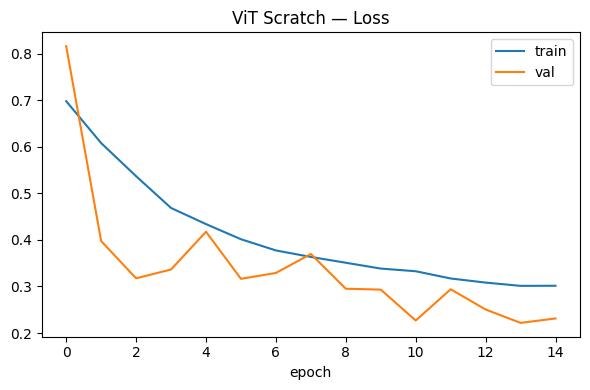

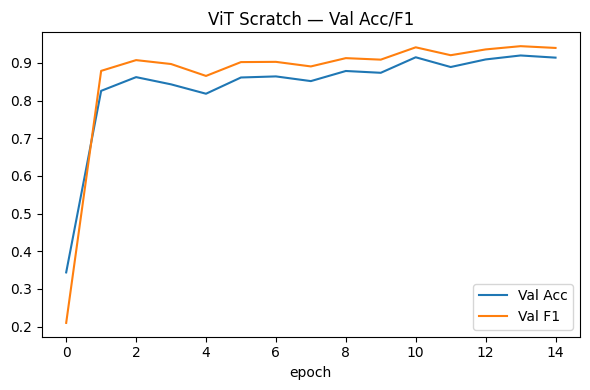

In [40]:

# Build scratch model
scratch_model = VisionTransformer(
    img_size=cfg.image_size, in_chans=cfg.in_channels, num_classes=2,
    embed_dim=cfg.embed_dim, depth=cfg.depth, num_heads=cfg.num_heads,
    mlp_ratio=cfg.mlp_ratio, drop_rate=cfg.drop_rate, drop_path_rate=cfg.drop_path_rate
).to(DEVICE)

# Optional class weights (inverse frequency)
cw = None
if cfg.use_class_weights:
    arr = np.array(train_counts, dtype=float)
    w = arr.sum() / (len(arr) * (arr + 1e-9))
    cw = torch.tensor(w, dtype=torch.float32)

# Train
scratch_model, hist_scratch, time_scratch = train_model(
    scratch_model, train_loader, val_loader, DEVICE,
    epochs=cfg.scratch_epochs, base_lr=cfg.scratch_lr, weight_decay=cfg.scratch_wd,
    class_weights=cw, monitor=cfg.monitor, patience=cfg.patience, tag="vit_scratch"
)

# Curves
plot_curve(hist_scratch["tr_loss"], hist_scratch["va_loss"], "ViT Scratch — Loss")
plot_two_series(hist_scratch["va_acc"], "Val Acc", hist_scratch["va_f1"], "Val F1",
                "ViT Scratch — Val Acc/F1")



In [41]:
# === Threshold helpers (recall-first with precision floor, and F-beta fallback) ===
import numpy as np
from sklearn.metrics import precision_recall_curve, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def choose_threshold_by_recall_precision(y_true, p1, min_recall=0.95, min_precision=0.85, beta=2.0):
    """
    Choose a threshold on p1 that satisfies a minimum recall, while keeping precision acceptable.
    - If any thresholds satisfy both recall>=min_recall and precision>=min_precision: take the one
      with the highest precision (ties broken by higher recall).
    - Else if any satisfy recall>=min_recall: take the one with the highest precision among those.
    - Else: fall back to maximizing F_beta (beta>1 biases toward recall).
    Returns: thr, recall_at_thr, precision_at_thr
    """
    prec, rec, thr = precision_recall_curve(y_true, p1)  # thr has length len(prec)-1
    prec, rec, thr = prec[:-1], rec[:-1], thr  # align lengths

    # 1) Both floors
    mask = (rec >= min_recall) & (prec >= min_precision)
    if np.any(mask):
        idxs = np.where(mask)[0]
        # pick by max precision, then max recall
        best = idxs[np.lexsort((rec[idxs], prec[idxs]))][-1]
        return float(thr[best]), float(rec[best]), float(prec[best])

    # 2) Recall floor only → best precision
    mask = (rec >= min_recall)
    if np.any(mask):
        idx = np.argmax(prec[mask])
        best = np.where(mask)[0][idx]
        return float(thr[best]), float(rec[best]), float(prec[best])

    # 3) F_beta fallback
    fbeta = (1+beta**2) * (prec*rec) / (beta**2*prec + rec + 1e-12)
    best = np.argmax(fbeta)
    return float(thr[best]), float(rec[best]), float(prec[best])

def summarize_at_threshold(y_true, p1, thr):
    """
    Compute metrics at a specific threshold thr on positive-class probability p1.
    """
    yhat = (p1 >= thr).astype(int)
    return {
        "acc": accuracy_score(y_true, yhat),
        "precision": precision_score(y_true, yhat, zero_division=0),
        "recall": recall_score(y_true, yhat, zero_division=0),
        "f1": f1_score(y_true, yhat, zero_division=0),
        "auroc": roc_auc_score(y_true, p1),
        "thr": float(thr),
    }

def plot_curve(tr, va, title):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(6,4))
    ep = range(len(tr))
    plt.plot(ep, tr, label="train")
    plt.plot(ep, va, label="val")
    plt.title(title); plt.xlabel("epoch"); plt.legend(); plt.tight_layout(); plt.show()


In [42]:
# === Recall-first evaluation (SCRATCH) ===
TARGET_RECALL   = 0.95   # keep high for screening
MIN_PRECISION   = 0.85   # floor to avoid predicting everyone positive
RECALL_FALLBACK = 2.0    # F-beta fallback weight if recall floor is infeasible

# VALIDATION → choose threshold
val_out_s = evaluate(scratch_model, val_loader, DEVICE)
y_val_s   = val_out_s["targets"]
probs_val_s = val_out_s.get("probs", None)
if probs_val_s is None:
    logits = val_out_s["logits"]
    import torch
    if not isinstance(logits, np.ndarray):
        logits = logits if isinstance(logits, torch.Tensor) else torch.tensor(logits)
        probs_val_s = torch.softmax(logits, dim=1).cpu().numpy()
    else:
        probs_val_s = logits
p1_val_s = probs_val_s[:,1]

thr_s, rec_val_s, prec_val_s = choose_threshold_by_recall_precision(
    y_val_s, p1_val_s,
    min_recall=TARGET_RECALL, min_precision=MIN_PRECISION, beta=RECALL_FALLBACK
)
print(f"[Scratch] chosen thr on VAL: {thr_s:.3f} (VAL recall={rec_val_s:.3f}, precision={prec_val_s:.3f})")

# TEST @0.5 and @recall-first
test_out_s = evaluate(scratch_model, test_loader, DEVICE)
y_test_s   = test_out_s["targets"]
probs_test_s = test_out_s.get("probs", None)
if probs_test_s is None:
    logits = test_out_s["logits"]
    import torch
    if not isinstance(logits, np.ndarray):
        logits = logits if isinstance(logits, torch.Tensor) else torch.tensor(logits)
        probs_test_s = torch.softmax(logits, dim=1).cpu().numpy()
    else:
        probs_test_s = logits
p1_test_s = probs_test_s[:,1]

summary_s_05   = summarize_at_threshold(y_test_s, p1_test_s, 0.5)
summary_s_reca = summarize_at_threshold(y_test_s, p1_test_s, thr_s)
print("[ViT Scratch @0.5] ", {k: round(v,4) for k,v in summary_s_05.items()})
print("[ViT Scratch @Rec] ", {k: round(v,4) for k,v in summary_s_reca.items()})

# Store for comparison
if 'vit_scratch_results' not in globals() or vit_scratch_results is None:
    vit_scratch_results = {}
vit_scratch_results["summary@0.5"]    = {k: float(v) for k,v in summary_s_05.items()}
vit_scratch_results["summary@recall"] = {k: float(v) for k,v in summary_s_reca.items()}
vit_scratch_results["thr_recall"]     = float(thr_s)
vit_scratch_results["params"]         = sum(p.numel() for p in scratch_model.parameters())
try: vit_scratch_results["time_sec"]  = float(time_scratch)
except: pass



[Scratch] chosen thr on VAL: 0.289 (VAL recall=0.951, precision=0.961)
[ViT Scratch @0.5]  {'acc': 0.7933, 'precision': 0.7843, 'recall': 0.9231, 'f1': 0.8481, 'auroc': 0.8892, 'thr': 0.5}
[ViT Scratch @Rec]  {'acc': 0.7788, 'precision': 0.752, 'recall': 0.9641, 'f1': 0.8449, 'auroc': 0.8892, 'thr': 0.289}


## Part B — Pretrained ViT‑B/16 (Google JAX `.npz`, offline)

[vit_google_npz_pretrained] epoch 01/10  tr_loss=0.2840  val_loss=0.1399  val_acc=0.9636  val_f1=0.9750  val_auroc=0.9972  (no_improve=0)
[vit_google_npz_pretrained] epoch 02/10  tr_loss=0.2169  val_loss=0.1137  val_acc=0.9703  val_f1=0.9798  val_auroc=0.9979  (no_improve=0)
[vit_google_npz_pretrained] epoch 03/10  tr_loss=0.2008  val_loss=0.1634  val_acc=0.9569  val_f1=0.9702  val_auroc=0.9988  (no_improve=0)
[vit_google_npz_pretrained] epoch 04/10  tr_loss=0.1957  val_loss=0.0931  val_acc=0.9856  val_f1=0.9903  val_auroc=0.9988  (no_improve=0)
[vit_google_npz_pretrained] epoch 05/10  tr_loss=0.1889  val_loss=0.0878  val_acc=0.9866  val_f1=0.9910  val_auroc=0.9986  (no_improve=1)
[vit_google_npz_pretrained] epoch 06/10  tr_loss=0.1783  val_loss=0.1126  val_acc=0.9789  val_f1=0.9856  val_auroc=0.9991  (no_improve=0)
[vit_google_npz_pretrained] epoch 07/10  tr_loss=0.1675  val_loss=0.0819  val_acc=0.9885  val_f1=0.9922  val_auroc=0.9970  (no_improve=1)
[vit_google_npz_pretrained] epoch 

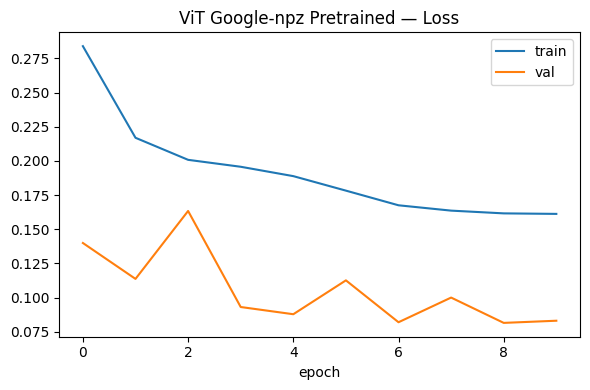

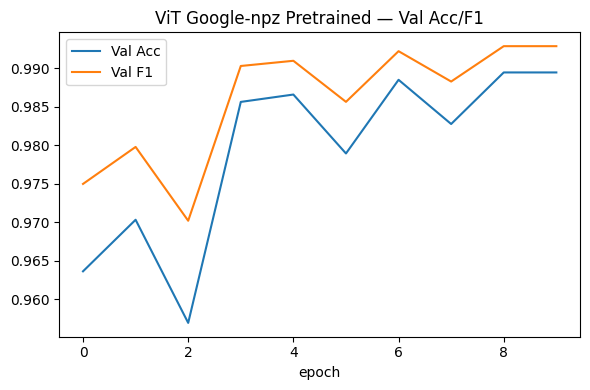

In [43]:

NPZ_PATH = WEIGHTS_DIR / "ViT-B_16.npz"
if not NPZ_PATH.exists():
    raise FileNotFoundError(f"Missing pretrained weights: {NPZ_PATH}. "
                            "Download from Google ViT bucket and place here.")

@torch.no_grad()
def _get_any(w, keys):
    for k in keys:
        if k in w: return w[k]
    raise KeyError(f"None of keys found: {keys}")

@torch.no_grad()
def load_jax_vit_npz_into_pytorch(model, npz_path: str | Path):
    w = np.load(str(npz_path))
    D = model.head.in_features  # 768 for B/16

    def n2t(x): return torch.from_numpy(x).float()

    # Patch embedding (JAX [P,P,in,D] -> torch conv [D,in,P,P])
    model.patch_embed.proj.weight.copy_(n2t(w['embedding/kernel']).permute(3,2,0,1))
    model.patch_embed.proj.bias.copy_(n2t(w['embedding/bias']))

    # [CLS] + positional embeddings
    model.cls_token.copy_(n2t(w['cls']))
    posemb = w['Transformer/posembed_input/pos_embedding']  # [1,1+N,D]
    if posemb.shape[1] != model.pos_embed.shape[1]:
        cls_pos = posemb[:, :1]
        grid_pos = posemb[:, 1:]
        gs_old = int(np.sqrt(grid_pos.shape[1]))
        grid_pos = grid_pos.reshape(1, gs_old, gs_old, D).transpose(0,3,1,2)  # 1,D,gh,gw
        H = W = int((model.patch_embed.num_patches) ** 0.5)
        grid_pos = F.interpolate(n2t(grid_pos), size=(H, W), mode='bicubic', align_corners=False)
        grid_pos = grid_pos.permute(0,2,3,1).reshape(1, H*W, D).numpy()
        posemb = np.concatenate([cls_pos, grid_pos], axis=1)
    model.pos_embed.copy_(n2t(posemb))

    # Helpers to reshape DenseGeneral/Bias
    def flatten_qkv(W, b):
        # W expected [D, H, Hd] or [D, D]; b [H, Hd] or [D]
        if W.ndim == 3:
            W = W.reshape(W.shape[0], -1)  # -> [D, D]
        b = b.reshape(-1)
        return W, b

    def flatten_out(Wo):
        # Wo [H, Hd, D] -> [D, D]
        if Wo.ndim == 3:
            Wo = Wo.reshape(-1, Wo.shape[-1])  # [H*Hd, D] == [D_in, D_out]
        elif Wo.ndim != 2:
            raise ValueError(f"Unexpected out-kernel ndim: {Wo.ndim}")
        return Wo.T  # -> [D_out, D_in]

    # Blocks
    for i, blk in enumerate(model.blocks):
        # Norms
        blk.norm1.weight.copy_(n2t(_get_any(w, [f'Transformer/encoderblock_{i}/LayerNorm_0/scale'])))
        blk.norm1.bias.copy_(n2t(_get_any(w,  [f'Transformer/encoderblock_{i}/LayerNorm_0/bias'])))
        blk.norm2.weight.copy_(n2t(_get_any(w, [f'Transformer/encoderblock_{i}/LayerNorm_2/scale'])))
        blk.norm2.bias.copy_(n2t(_get_any(w,  [f'Transformer/encoderblock_{i}/LayerNorm_2/bias'])))

        # Attention q/k/v
        Wq = _get_any(w, [f'Transformer/encoderblock_{i}/MultiHeadDotProductAttention_1/query/kernel'])
        bq = _get_any(w, [f'Transformer/encoderblock_{i}/MultiHeadDotProductAttention_1/query/bias'])
        Wk = _get_any(w, [f'Transformer/encoderblock_{i}/MultiHeadDotProductAttention_1/key/kernel'])
        bk = _get_any(w, [f'Transformer/encoderblock_{i}/MultiHeadDotProductAttention_1/key/bias'])
        Wv = _get_any(w, [f'Transformer/encoderblock_{i}/MultiHeadDotProductAttention_1/value/kernel'])
        bv = _get_any(w, [f'Transformer/encoderblock_{i}/MultiHeadDotProductAttention_1/value/bias'])

        Wq, bq = flatten_qkv(Wq, bq)
        Wk, bk = flatten_qkv(Wk, bk)
        Wv, bv = flatten_qkv(Wv, bv)

        Wqkv = np.concatenate([Wq, Wk, Wv], axis=1).T  # [3D, D]
        bqkv = np.concatenate([bq, bk, bv], axis=0)    # [3D]
        blk.attn.qkv.weight.copy_(n2t(Wqkv))
        blk.attn.qkv.bias.copy_(n2t(bqkv))

        # Attention out
        Wo = _get_any(w, [f'Transformer/encoderblock_{i}/MultiHeadDotProductAttention_1/out/kernel'])
        bo = _get_any(w, [f'Transformer/encoderblock_{i}/MultiHeadDotProductAttention_1/out/bias'])
        blk.attn.proj.weight.copy_(n2t(flatten_out(Wo)))
        blk.attn.proj.bias.copy_(n2t(bo))

        # MLP — support both key schemes: 'Mlp/Dense_0' and 'MlpBlock_3/Dense_0'
        Wm0 = _get_any(w, [f'Transformer/encoderblock_{i}/Mlp/Dense_0/kernel',
                           f'Transformer/encoderblock_{i}/MlpBlock_3/Dense_0/kernel'])
        bm0 = _get_any(w, [f'Transformer/encoderblock_{i}/Mlp/Dense_0/bias',
                           f'Transformer/encoderblock_{i}/MlpBlock_3/Dense_0/bias'])
        Wm1 = _get_any(w, [f'Transformer/encoderblock_{i}/Mlp/Dense_1/kernel',
                           f'Transformer/encoderblock_{i}/MlpBlock_3/Dense_1/kernel'])
        bm1 = _get_any(w, [f'Transformer/encoderblock_{i}/Mlp/Dense_1/bias',
                           f'Transformer/encoderblock_{i}/MlpBlock_3/Dense_1/bias'])
        blk.mlp.fc1.weight.copy_(n2t(Wm0).T); blk.mlp.fc1.bias.copy_(n2t(bm0))
        blk.mlp.fc2.weight.copy_(n2t(Wm1).T); blk.mlp.fc2.bias.copy_(n2t(bm1))

    # Final encoder LN
    model.norm.weight.copy_(n2t(w['Transformer/encoder_norm/scale']))
    model.norm.bias.copy_(n2t(w['Transformer/encoder_norm/bias']))
    return model

# Build a ViT-B/16 backbone compatible with the checkpoint (D=768, L=12, H=12)
vit_b16 = VisionTransformer(
    img_size=cfg.image_size, patch_size=16, in_chans=3, num_classes=2,
    embed_dim=768, depth=12, num_heads=12, mlp_ratio=4.0, drop_rate=0.0, drop_path_rate=0.0
).to(DEVICE)

# Load weights
vit_b16 = load_jax_vit_npz_into_pytorch(vit_b16, NPZ_PATH)

# Optional: freeze shallow blocks for stability
# for n,p in vit_b16.named_parameters():
#     if n.startswith("blocks.0") or n.startswith("blocks.1"):
#         p.requires_grad = False

# Class weights (same as scratch)
cw = None
if cfg.use_class_weights:
    arr = np.array(train_counts, dtype=float)
    w = arr.sum() / (len(arr) * (arr + 1e-9))
    cw = torch.tensor(w, dtype=torch.float32)

# Fine-tune
pt_model, hist_pt, time_pt = train_model(
    vit_b16, train_loader, val_loader, DEVICE,
    epochs=cfg.pretrained_epochs, base_lr=cfg.pretrained_lr, weight_decay=cfg.pretrained_wd,
    class_weights=cw, monitor=cfg.monitor, patience=cfg.patience, tag="vit_google_npz_pretrained"
)

# Curves
plot_curve(hist_pt["tr_loss"], hist_pt["va_loss"], "ViT Google-npz Pretrained — Loss")
plot_two_series(hist_pt["va_acc"], "Val Acc", hist_pt["va_f1"], "Val F1",
                "ViT Google-npz Pretrained — Val Acc/F1")

In [44]:
# === Recall-first evaluation (PRETRAINED) ===
TARGET_RECALL = 0.95
MIN_PRECISION = 0.85
RECALL_FALLBACK = 2.0

# VALIDATION → choose threshold
val_out_p  = evaluate(pt_model, val_loader, DEVICE)
y_val_p    = val_out_p["targets"]
probs_val_p = val_out_p.get("probs", None)
if probs_val_p is None:
    logits = val_out_p["logits"]
    import torch
    if not isinstance(logits, np.ndarray):
        logits = logits if isinstance(logits, torch.Tensor) else torch.tensor(logits)
        probs_val_p = torch.softmax(logits, dim=1).cpu().numpy()
    else:
        probs_val_p = logits
p1_val_p = probs_val_p[:,1]

thr_p, rec_val_p, prec_val_p = choose_threshold_by_recall_precision(
    y_val_p, p1_val_p,
    min_recall=TARGET_RECALL, min_precision=MIN_PRECISION, beta=RECALL_FALLBACK
)
print(f"[Pretrained] chosen thr on VAL: {thr_p:.3f} (VAL recall={rec_val_p:.3f}, precision={prec_val_p:.3f})")

# TEST
test_out_p  = evaluate(pt_model, test_loader, DEVICE)
y_test_p    = test_out_p["targets"]
probs_test_p = test_out_p.get("probs", None)
if probs_test_p is None:
    logits = test_out_p["logits"]
    import torch
    if not isinstance(logits, np.ndarray):
        logits = logits if isinstance(logits, torch.Tensor) else torch.tensor(logits)
        probs_test_p = torch.softmax(logits, dim=1).cpu().numpy()
    else:
        probs_test_p = logits
p1_test_p = probs_test_p[:,1]

summary_p_05   = summarize_at_threshold(y_test_p, p1_test_p, 0.5)
summary_p_reca = summarize_at_threshold(y_test_p, p1_test_p, thr_p)
print("[ViT Pretrained @0.5]", {k: round(v,4) for k,v in summary_p_05.items()})
print("[ViT Pretrained @Rec]", {k: round(v,4) for k,v in summary_p_reca.items()})

# Store for comparison
vit_pretrained_results = {
    "summary@0.5":   {k: float(v) for k,v in summary_p_05.items()},
    "summary@recall":{k: float(v) for k,v in summary_p_reca.items()},
    "thr_recall":    float(thr_p),
    "params":        sum(p.numel() for p in pt_model.parameters())
}
try: vit_pretrained_results["time_sec"] = float(time_pt)
except: pass



[Pretrained] chosen thr on VAL: 0.216 (VAL recall=0.985, precision=0.999)
[ViT Pretrained @0.5] {'acc': 0.8702, 'precision': 0.8337, 'recall': 0.9897, 'f1': 0.905, 'auroc': 0.9007, 'thr': 0.5}
[ViT Pretrained @Rec] {'acc': 0.8413, 'precision': 0.7988, 'recall': 0.9974, 'f1': 0.8871, 'auroc': 0.9007, 'thr': 0.2159}


## Part C — Scratch vs Pretrained: comparison table

In [45]:
# === Comparison table (use recall-first summaries) ===
import pandas as pd
rows = []
def add_row(name, res):
    if not res: return
    r = res.get("summary@recall", res.get("summary@0.5", {}))
    rows.append({
        "Model": name,
        "Params (M)": round(res.get("params", 0)/1e6, 2),
        "Time (min)": round(res.get("time_sec", 0)/60.0, 2),
        "Acc":   round(r.get("acc", 0.0), 4),
        "Prec":  round(r.get("precision", 0.0), 4),
        "Recall":round(r.get("recall", 0.0), 4),
        "F1":    round(r.get("f1", 0.0), 4),
        "AUROC": round(r.get("auroc", 0.0), 4),
        "Thr":   round(res.get("thr_recall", res.get("threshold", 0.5)), 3),
    })

add_row("ViT (scratch)",    vit_scratch_results)
add_row("ViT (pretrained)", vit_pretrained_results)
pd.DataFrame(rows)



,Model,Params (M),Time (min),Acc,Prec,Recall,F1,AUROC,Thr
0,ViT (scratch),4.99,27.60,0.7788,0.7520,0.9641,0.8449,0.8892,0.289
1,ViT (pretrained),85.80,44.14,0.8413,0.7988,0.9974,0.8871,0.9007,0.216
